In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import random_split
import torch.nn.functional as F

from tqdm import tqdm

from aegear.model import EfficientUNet, TemporalRefinedUNet
from aegear.datasets import FishHeatmapSequenceDataset

In [2]:
# Cell 2: Load EfficientUNet model (assume pretrained weights exist)
device = "cuda" if torch.cuda.is_available() else "cpu"
unet_model = EfficientUNet()
unet_model.load_state_dict(torch.load("../data/models/model_efficient_unet_2025-04-04.pth", map_location=device))
unet_model.eval()
unet_model.to(device);

print("Model loaded and moved to device:", device)

# Freeze up UNet, as we already have it at a very good state.
for name, param in unet_model.named_parameters():
    if "enc" in name:
        param.requires_grad = False

Model loaded and moved to device: cuda


In [3]:
import gdown

# 3. Download the data if not already in place
dataset_dir = '../data/training'
annotations_file = os.path.join(dataset_dir, 'tracking_E7_filtered.json')
video_dir = "../data/video"

os.makedirs(dataset_dir, exist_ok=True)

# Check if each of the dataset units is present
if not os.path.exists(annotations_file):
    print("Downloading dataset...")
    # Google Drive share link
    file_id = "1osZGb1Wc_iZ-mCAV54OhTwsmPN88nZ3y"
    url = f'https://drive.google.com/uc?id={file_id}'

    gdown.download(url, annotations_file, quiet=False)

if not os.path.exists(video_dir):
    print("Downloading video...")

    # Google Drive share link
    file_id = "1FJypI1WmZJj4iEo9nVfBvP8FjaoDf1Ob"
    url = f'https://drive.google.com/uc?id={file_id}'

    output = os.path.join(dataset_dir, "E7.MOV")
    gdown.download(url,output, quiet=False)

In [4]:
dataset = FishHeatmapSequenceDataset(
    tracking_json_path=annotations_file,
    unet_model=unet_model,
    video_dir=video_dir,
    device=device,
    history_lookback_s=(0.5, 1.0),
    n_history_samples=TemporalRefinedUNet.HISTORY_LEN,
    future_horizon_s=0.15,
    n_history_caches=0,
    interpolation_smoothness=5.0,
    cache_path="../data/models/grutracker/training_cache",
)

val_fraction = 0.1
val_size = int(len(dataset) * val_fraction)
train_size = len(dataset) - val_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Loaded cached sequence data from ../data/models/grutracker/training_cache
Creating shared heatmap cache...
Shared heatmap cache created.
Train dataset size: 32145
Validation dataset size: 3571


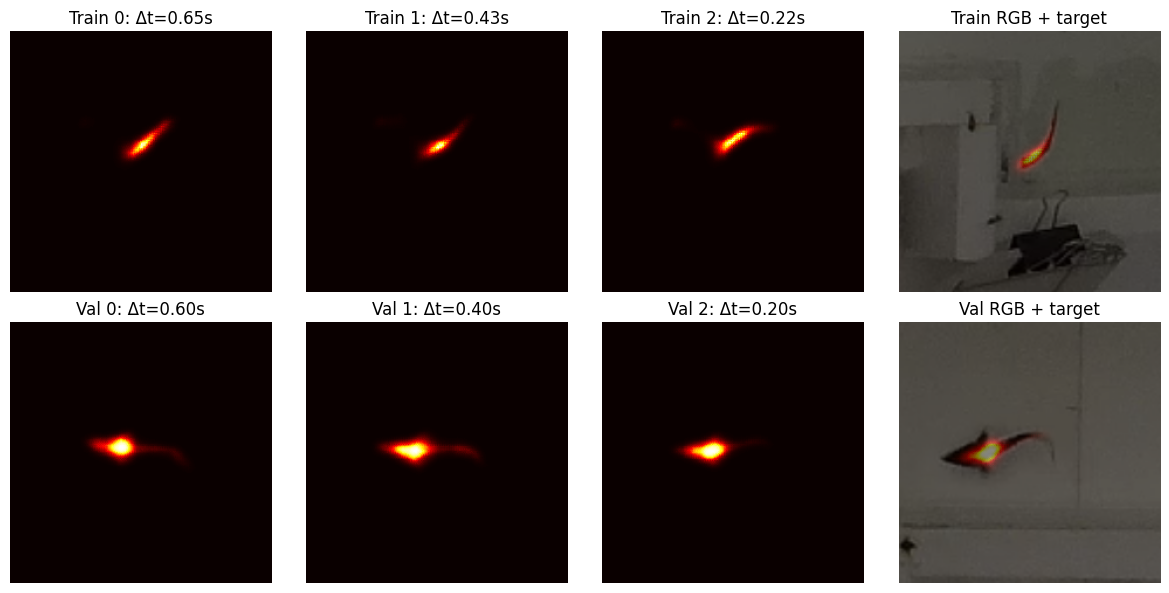

In [10]:
import random
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

# Unnormalize transform
def unnormalize(t):
    mean = torch.tensor([0.485, 0.456, 0.406])[:, None, None]
    std = torch.tensor([0.229, 0.224, 0.225])[:, None, None]
    return t * std + mean

# Sample two random dataset items
random_train_idx = random.randint(0, len(train_dataset) - 1)
random_val_idx = random.randint(0, len(val_dataset) - 1)

train_sample = train_dataset[random_train_idx]
val_sample = val_dataset[random_val_idx]

# Unpack
train_heatmaps = train_sample["history_heatmaps"]
train_timestamps = train_sample["history_timestamps"]
train_img = train_sample["current_rgb"]
train_target = train_sample["target_heatmap"]
train_ts = train_sample["current_timestamp"].item()

val_heatmaps = val_sample["history_heatmaps"]
val_timestamps = val_sample["history_timestamps"]
val_img = val_sample["current_rgb"]
val_target = val_sample["target_heatmap"]
val_ts = val_sample["current_timestamp"].item()

T = train_heatmaps.shape[0]
fig, axs = plt.subplots(2, T + 1, figsize=((T + 1) * 3, 6))

# Plot train sequence
for i in range(T):
    t_dt = train_ts - train_timestamps[i].item()
    axs[0, i].imshow(train_heatmaps[i, 0], cmap='hot')
    axs[0, i].set_title(f"Train {i}: Δt={t_dt:.2f}s")
    axs[0, i].axis('off')

train_img_np = TF.to_pil_image(unnormalize(train_img).clamp(0, 1))
axs[0, T].imshow(train_img_np)
axs[0, T].imshow(train_target[0], cmap='hot', alpha=0.5)
axs[0, T].set_title("Train RGB + target")
axs[0, T].axis('off')

# Plot val sequence
for i in range(T):
    v_dt = val_ts - val_timestamps[i].item()
    axs[1, i].imshow(val_heatmaps[i, 0], cmap='hot')
    axs[1, i].set_title(f"Val {i}: Δt={v_dt:.2f}s")
    axs[1, i].axis('off')

val_img_np = TF.to_pil_image(unnormalize(val_img).clamp(0, 1))
axs[1, T].imshow(val_img_np)
axs[1, T].imshow(val_target[0], cmap='hot', alpha=0.5)
axs[1, T].set_title("Val RGB + target")
axs[1, T].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Cell 6: Instantiate model, loss, optimizer
model = TemporalRefinedUNet(unet_model).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def temporal_smoothness_loss(history_heatmaps):
    """
    Penalizes sudden changes in the predicted centroid motion.
    Encourages the GRU to output heatmaps with consistent movement.

    history_heatmaps: [B, T, 1, H, W]
    """
    B, T, _, H, W = history_heatmaps.shape
    centroids = []

    for t in range(T):
        heat = history_heatmaps[:, t, 0]  # [B, H, W]
        flat = heat.view(B, -1)
        indices = flat.argmax(dim=1)  # [B]
        ys = indices // W
        xs = indices % W
        centroids.append(torch.stack([xs, ys], dim=1).float())  # [B, 2]

    centroids = torch.stack(centroids, dim=1)  # [B, T, 2]
    deltas = centroids[:, 1:] - centroids[:, :-1]  # [B, T-1, 2]

    # Smoothness: prefer small second derivative (acceleration)
    accel = deltas[:, 1:] - deltas[:, :-1]  # [B, T-2, 2]
    return accel.pow(2).mean()


def weighted_bce_with_logits(pred, target, limit=0.8, pos_weight=20.0):
    weights = torch.ones_like(target)
    weights[target > limit] = pos_weight  # emphasize center of Gaussian

    bce = F.binary_cross_entropy_with_logits(pred, target, weight=weights, reduction='mean')
    return bce

def loss_fn(pred, target, history_heatmaps, alpha=0.5):
    """
    Loss function for the GRU tracker.
    """
    # BCE loss
    bce_loss = weighted_bce_with_logits(pred, target)

    # Temporal smoothness loss
    ts_loss = temporal_smoothness_loss(history_heatmaps)

    # Combine losses
    return bce_loss + alpha * ts_loss

model_dir = '../data/models/grutracker'
log_dir = f'{model_dir}/runs'
checkpoint_dir = f'{model_dir}/checkpoints'

In [ ]:


os.makedirs(model_dir, exist_ok=True)
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

writer = SummaryWriter(log_dir=log_dir, flush_secs=1)
best_val_loss = float('inf')
losses = []

epochs = 10
epoch_save_interval = 10

for epoch in range(epochs):
    model.train()
    train_loss = 0.0

    train_bar = tqdm(train_loader, desc=f"Training batches {epoch + 1}", leave=False)
    for batch in train_bar:
        history = (
            batch["history_heatmaps"].to(device),
            batch["history_timestamps"].to(device)
        )

        rgb = batch["current_rgb"].to(device)
        ts = batch["current_timestamp"].to(device)
        target = batch["target_heatmap"].to(device)

        preds = model(rgb, ts, history=history)

        loss = loss_fn(preds, target, history[0])
        train_bar.set_postfix(loss=loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        val_bar = tqdm(val_loader, desc=f"Validation batches {epoch + 1}", leave=False)

        for batch in val_bar:
            history = (
                batch["history_heatmaps"].to(device),
                batch["history_timestamps"].to(device)
            )

            rgb = batch["current_rgb"].to(device)
            ts = batch["current_timestamp"].to(device)
            target = batch["target_heatmap"].to(device)

            preds = model(rgb, ts, history=history)

            loss = loss_fn(preds, target, history[0])
            val_bar.set_postfix(loss=loss.item())

            val_loss += loss.item()

    n_train = len(train_loader)
    train_loss /= n_train
    val_loss /= len(val_loader)

    losses.append((train_loss, val_loss))

    writer.add_scalar('Loss/train_total', train_loss, epoch)
    writer.add_scalar('Loss/val_total', val_loss, epoch)

    print(f"Epoch {epoch + 1}/{epochs} - Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        print(f"New best model at epoch {epoch + 1} with val loss: {val_loss:.4f}")
        best_val_loss = val_loss
        torch.save(model.state_dict(), f'{model_dir}/best_model.pth')

    if (epoch + 1) % epoch_save_interval == 0:
        torch.save(model.state_dict(), os.path.join(checkpoint_dir, f'model_epoch_{epoch+1}.pth'))

writer.close()

Epoch 1/10 - Train loss: 0.0546, Val loss: 0.0210
New best model at epoch 1 with val loss: 0.0210


Epoch 2/10 - Train loss: 0.0203, Val loss: 0.0198
New best model at epoch 2 with val loss: 0.0198


Epoch 3/10 - Train loss: 0.0196, Val loss: 0.0190
New best model at epoch 3 with val loss: 0.0190


Epoch 4/10 - Train loss: 0.0190, Val loss: 0.0185
New best model at epoch 4 with val loss: 0.0185


Epoch 5/10 - Train loss: 0.0187, Val loss: 0.0183
New best model at epoch 5 with val loss: 0.0183


Epoch 6/10 - Train loss: 0.0184, Val loss: 0.0180
New best model at epoch 6 with val loss: 0.0180


Epoch 7/10 - Train loss: 0.0182, Val loss: 0.0179
New best model at epoch 7 with val loss: 0.0179


Epoch 8/10 - Train loss: 0.0180, Val loss: 0.0178
New best model at epoch 8 with val loss: 0.0178


Epoch 9/10 - Train loss: 0.0179, Val loss: 0.0177
New best model at epoch 9 with val loss: 0.0177


Epoch 10/10 - Train loss: 0.0178, Val loss: 0.0176
New best model at epoch 10 with val loss: 0.0176


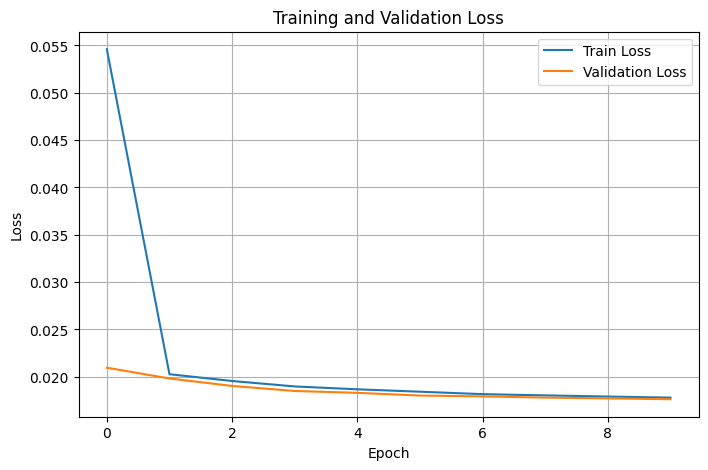

In [13]:
# 7. Plotting the losses
import matplotlib.pyplot as plt

train_losses, val_losses = zip(*losses)

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# Load the best model for inference
model.load_state_dict(torch.load(f'{model_dir}/best_model.pth'))

<All keys matched successfully>

In [8]:
print("\nRunning evaluation on validation set...")

model.eval()
history_losses = []
vanilla_losses = []

with torch.no_grad():
    for batch in val_loader:
        history = (
            batch["history_heatmaps"].to(device),         # [B, T, 1, H, W]
            batch["history_timestamps"].to(device)        # [B, T]
        )
        rgb = batch["current_rgb"].to(device)             # [B, 3, H, W]
        ts = batch["current_timestamp"].to(device)        # [B]
        target = batch["target_heatmap"].to(device)       # [B, 1, H, W]

        # --- Prediction with history
        preds_with = model(rgb, ts, history=history)
        loss_with = weighted_bce_with_logits(preds_with, target).item()
        history_losses.append(loss_with)

        # --- Prediction without history (vanilla EfficientUNet)
        preds_vanilla = model(rgb, ts, history=None)
        loss_vanilla = weighted_bce_with_logits(preds_vanilla, target).item()
        vanilla_losses.append(loss_vanilla)

mean_hist = sum(history_losses) / len(history_losses)
mean_vanilla = sum(vanilla_losses) / len(vanilla_losses)

print(f"Validation Loss (with history):   {mean_hist:.6f}")
print(f"Validation Loss (no history):     {mean_vanilla:.6f}")



Running evaluation on validation set...
Validation Loss (with history):   0.017572
Validation Loss (no history):     0.021078


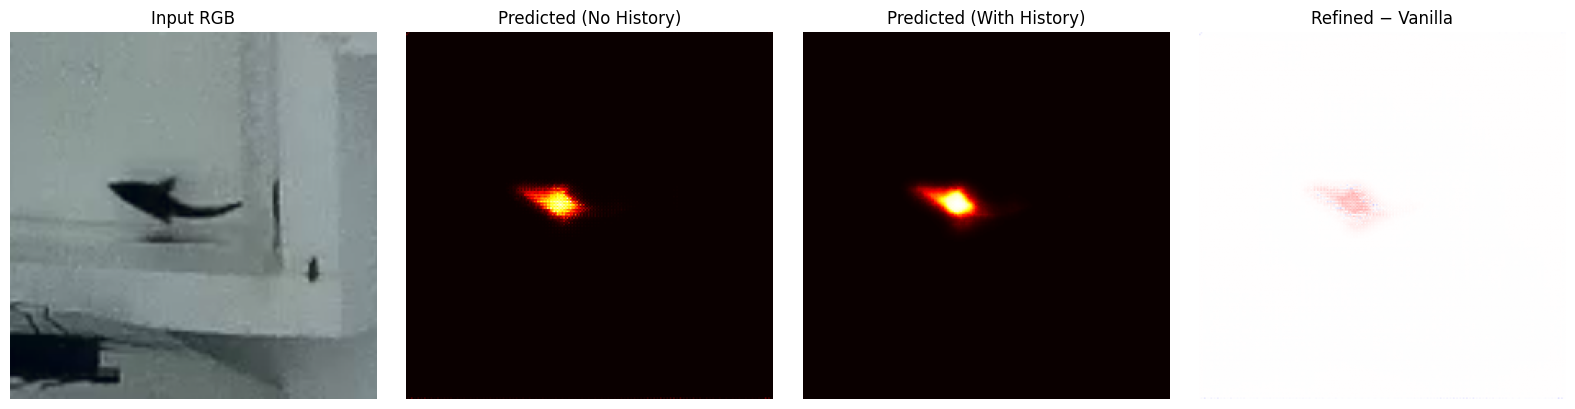

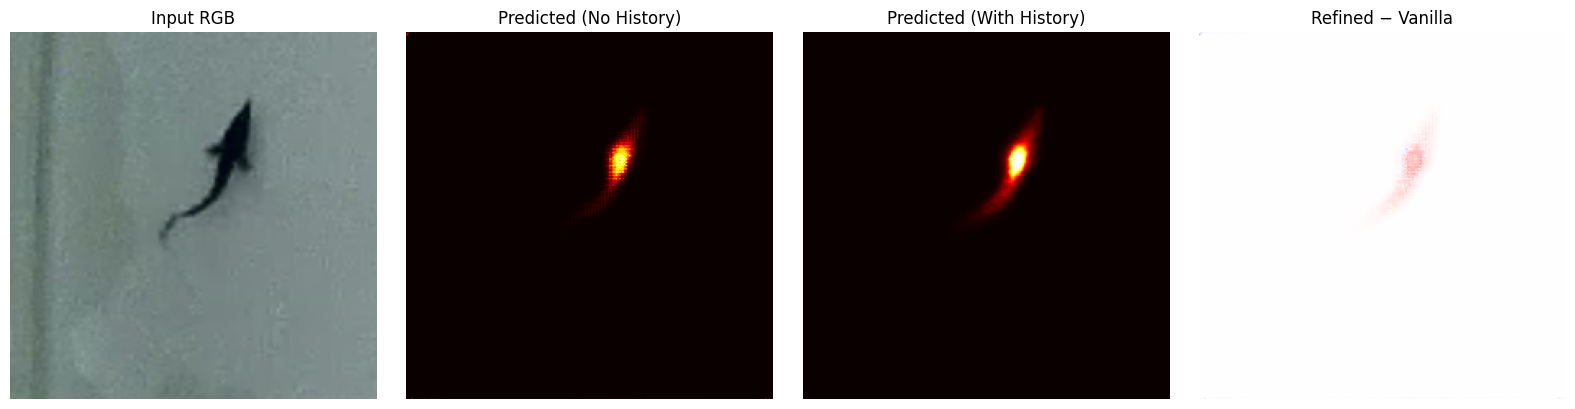

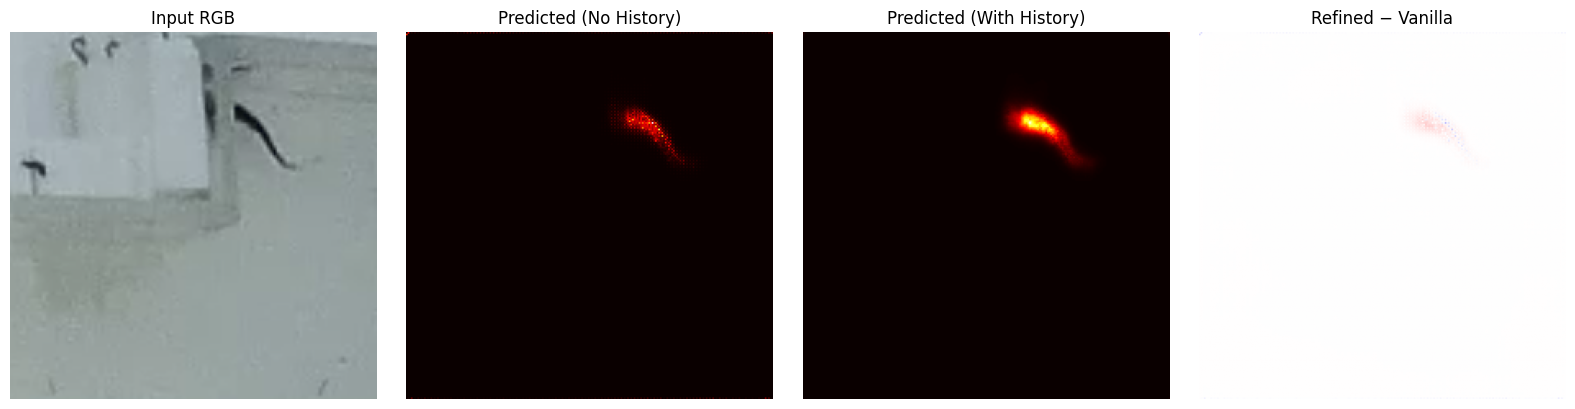

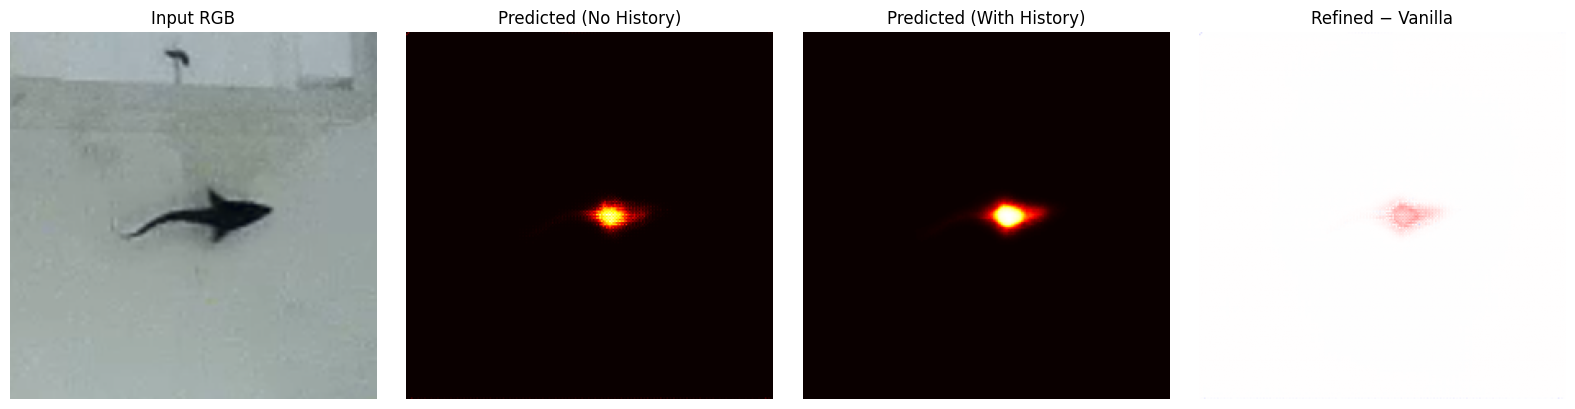

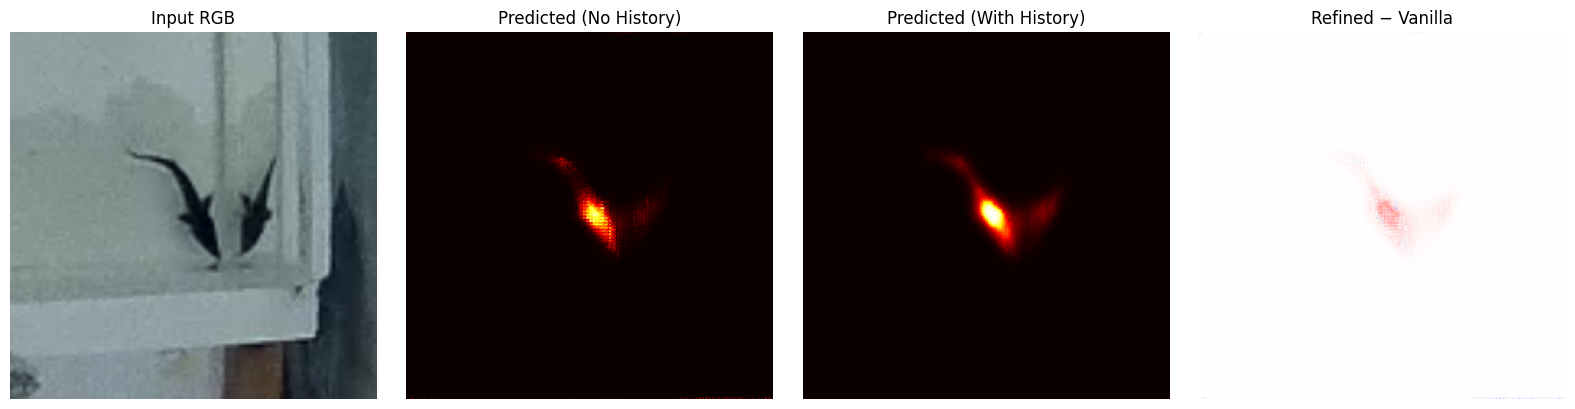

In [10]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random

model.eval()

N = 5  # number of samples to visualize
indices = random.sample(range(len(val_dataset)), N)

for idx in indices:
    batch = val_dataset[idx]
    rgb = batch["current_rgb"].unsqueeze(0).to(device)
    ts = batch["current_timestamp"].unsqueeze(0).to(device)
    target = batch["target_heatmap"].squeeze().numpy()

    history = (
        batch["history_heatmaps"].unsqueeze(0).to(device),
        batch["history_timestamps"].unsqueeze(0).to(device),
    )

    with torch.no_grad():
        pred_vanilla = model(rgb, ts).squeeze().sigmoid().cpu().numpy()
        pred_refined = model(rgb, ts, history=history).squeeze().sigmoid().cpu().numpy()

    fig, axs = plt.subplots(1, 4, figsize=(16, 4))

    axs[0].imshow(rgb.squeeze().permute(1, 2, 0).cpu().numpy() * 0.229 + 0.485)  # undo normalize
    axs[0].set_title("Input RGB")
    axs[0].axis('off')

    axs[1].imshow(pred_vanilla, cmap='hot')
    axs[1].set_title("Predicted (No History)")

    axs[2].imshow(pred_refined, cmap='hot')
    axs[2].set_title("Predicted (With History)")

    diff = pred_refined - pred_vanilla
    axs[3].imshow(diff, cmap='bwr', vmin=-1, vmax=1)
    axs[3].set_title("Refined − Vanilla")

    for ax in axs:
        ax.axis('off')

    plt.tight_layout()
    plt.show()
